In [137]:
import torch
import numpy as np

from tqdm import tqdm

from model.u_net_2 import UNet2
from util.dataset import load_celeb_a
from util.plot_images import plot_images
from util.model_util import load_checkpoint
from util.function_util import fourier_sample

def generate_conditional_images(model, device, data, n_images, n_recursions, use_fourier_sampling, y, reconstruct=False):
    """If reconstruct, reconstruct with new label vector"""
    assert n_recursions > 0, f"n_recursions must be greater than 0! Got {n_recursions}"

    batch, _ = next(iter(data))
    original = torch.empty(n_images, *next(iter(data))[0].shape[1:])
    reconstructed = torch.empty(n_images, n_recursions, *batch.shape[1:])

    with torch.inference_mode():
        if reconstruct:
            for i, (x, _) in tqdm(enumerate(data), total=n_images):
                if i == n_images:
                    break

                original[i] = x[0]
                x_hat = x[:1].to(device)

                for j in range(n_recursions):
                    x_hat = model(x_hat, y)
                    reconstructed[i, j] = x_hat[0].cpu()
        else:
            for i in tqdm(range(n_images)):
                if use_fourier_sampling:
                    x = fourier_sample(batch)
                else:
                    x = torch.randn_like(batch)

                original[i] = x[0].clamp(-1.0, 1.0).cpu()
                x_hat = x[:1].to(device) # Take first image, keeping batch dim

                for j in range(n_recursions):
                    x_hat = model(x_hat, y)
                    reconstructed[i, j] = x_hat[0].cpu()
    
    return original, reconstructed


In [138]:
def names_to_attributes(attr_names: np.ndarray, names: set):
    ret = list()
    for attr in attr_names:
        if attr in names or attr.lower() in names:
            ret.append(1)
        else:
            ret.append(0)
            
    return torch.tensor(ret)[None, :] # return shape (1, len(attr_names))

def attributes_to_names(attr_names: np.ndarray, y: list):
    return attr_names[np.where(y[0])].tolist()

In [139]:
names = {
'5_o_clock_shadow': False,
'arched_eyebrows': False,
'attractive': True,
'bags_under_eyes': False,
'bald': False,
'bangs': False,
'big_lips': False,
'big_nose': True,
'black_hair': False,
'blond_hair': False,
'blurry': False,
'brown_hair': True,
'bushy_eyebrows': False,
'chubby': False,
'double_chin': False,
'eyeglasses': False,
'goatee': False,
'gray_hair': False,
'heavy_makeup': False,
'high_cheekbones': False,
'male': True,
'mouth_slightly_open': True,
'mustache': False,
'narrow_eyes': False,
'no_beard': False,
'oval_face': False,
'pale_skin': False,
'pointy_nose': True,
'receding_hairline': False,
'rosy_cheeks': True,
'sideburns': True,
'smiling': True,
'straight_hair': False,
'wavy_hair': False,
'wearing_earrings': True,
'wearing_hat': False,
'wearing_lipstick': False,
'wearing_necklace': True,
'wearing_necktie': False,
'young': False,
}
names = {k for k, v in names.items() if v}

In [142]:
run_id = "CELEBA_CONDITIONAL_UNET_2_best_model"

# Setup
n_images = 10
n_recursions = 3
normalized = True # True if images are in range [-1, 1]

# Loading model and data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
checkpoint = load_checkpoint(f"checkpoints/{run_id}.pt")
model = UNet2(device)
model.load_state_dict(checkpoint["model_state_dict"])

use_fourier_sampling = checkpoint['config']['training']['use_fourier_sampling']
data = load_celeb_a(batch_size=checkpoint['config']['training']['batch_size'], split='test')

model.to(device)
model.eval()

attr_names = np.array(data.dataset.attr_names)[:-1] # Last is a blank string for some reason

/media/simon/AE989A9A989A609F/Users/Simon/Documents/Github/KTH-DD2412-Idempotent-GenNets/util/model_util.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = tor

Files already downloaded and verified


['Attractive', 'Big_Nose', 'Brown_Hair', 'Male', 'Mouth_Slightly_Open', 'Pointy_Nose', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Wearing_Earrings', 'Wearing_Necklace']


100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


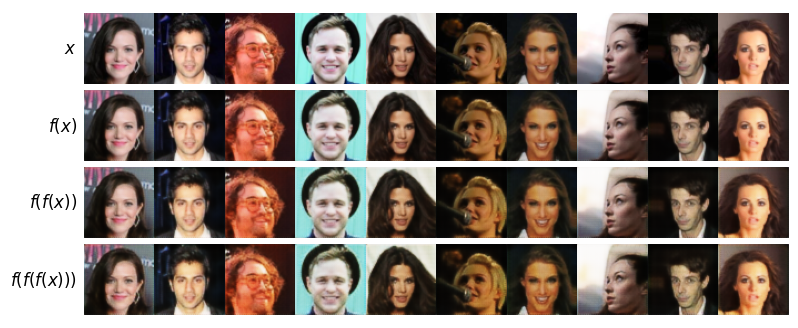

In [143]:
y = names_to_attributes(attr_names, names)
print(attributes_to_names(attr_names, y))
original, reconstructed = generate_conditional_images(model=model, device=device, data=data, n_images=n_images, n_recursions=n_recursions, use_fourier_sampling=use_fourier_sampling, y=y, reconstruct=True)
plot_images(original, reconstructed, grayscale=False, normalized=normalized)

['5_o_Clock_Shadow', 'Bushy_Eyebrows', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Lipstick', 'Wearing_Necklace', 'Young']


100%|██████████| 10/10 [00:00<00:00, 22.59it/s]


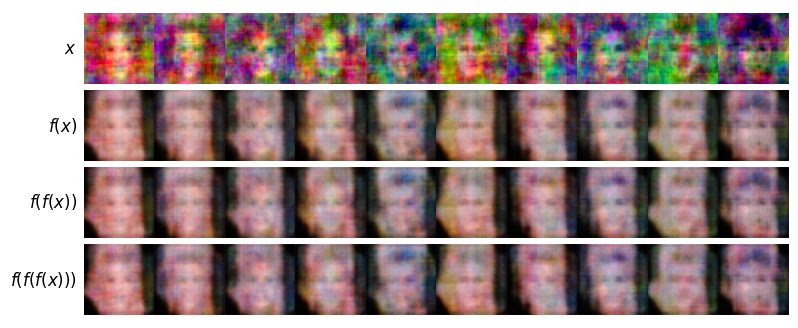

In [151]:
y = names_to_attributes(attr_names, np.random.choice(attr_names, np.random.randint(0,10), replace=False))
print(attributes_to_names(attr_names, y))
original, reconstructed = generate_conditional_images(model=model, device=device, data=data, n_images=n_images, n_recursions=n_recursions, use_fourier_sampling=use_fourier_sampling, y=y if len(y) > 0 else None)
plot_images(original, reconstructed, grayscale=False, normalized=normalized)

100%|██████████| 10/10 [00:00<00:00, 24.75it/s]


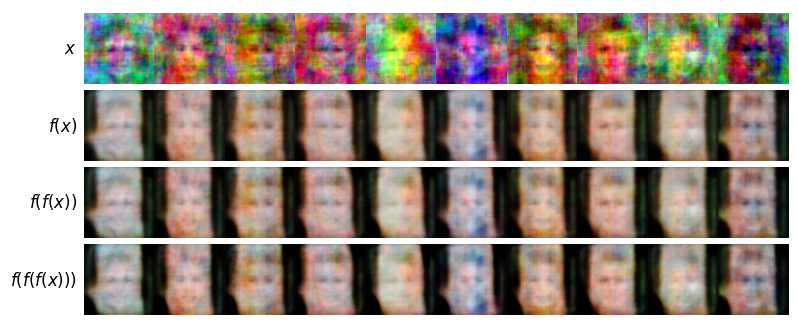

In [145]:
original, reconstructed = generate_conditional_images(model=model, device=device, data=data, n_images=n_images, n_recursions=n_recursions, use_fourier_sampling=use_fourier_sampling, y=None)
plot_images(original, reconstructed, grayscale=False, normalized=normalized)